In [1]:
import math 
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from scipy import stats

# plt.rcParams['font.family'] = 'Lato'

import netam
from netam.framework import add_shm_model_outputs_to_pcp_df
from netam.sequences import translate_sequences

from dnsmex import dasm_oe
from dnsmex.dasm_zoo import validation_burrito_of_pcp_df
from dnsmex.dxsm_data import pcp_df_of_nickname
from dnsmex.local import localify
from dnsmex.ablang_wrapper import AbLangWrapper

os.makedirs("_output", exist_ok=True)

In [2]:
model_name = "ablang2-paired"

dataset_name = "v1rodriguez"

ablang = AbLangWrapper(model_name, device="cpu")

/Users/matsen/re/netam/.venv/lib/python3.11/site-packages/ablang2/load_model.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(


In [3]:
pcp_df = pcp_df_of_nickname("v1rodriguez", add_shm_outputs=False)
assert (pcp_df["parent_is_naive"] == False).all()

pcp_df["parent_h_aa"] = translate_sequences(pcp_df["parent_heavy"])
pcp_df["child_h_aa"] = translate_sequences(pcp_df["child_heavy"])

# Only consider sequences with AA changes.
pcp_df = pcp_df[pcp_df["parent_h_aa"] != pcp_df["child_h_aa"]]

eval_count = 1000

# take eval_count evenly spaced samples from pcp_df
pcp_df = pcp_df.iloc[::math.ceil(len(pcp_df) / eval_count)]

Loading /Users/matsen/data/v3/rodriguez-airr-seq-race-prod-NoWinCheck_igh_pcp_2024-11-12_MASKED_NI_noN_no-naive.csv.gz
Filtering out problematic pairs of sample_id and clonal families [('sample-igg-SC-18', '440')]


In [4]:
# Very expensive calculation, so commented out.
# perplexities = ablang.csp_perplexity_heavy(pcp_df["parent_h_aa"], pcp_df["child_h_aa"], stepwise_masking=True)
# output_df = pd.DataFrame({"pcp_index": pcp_df.index, "AbLang2 perplexity": perplexities})

output_path = f"_output/perplexities-{dataset_name}.csv"
output_df = pd.read_csv(output_path)

In [5]:
dasm_crepe_prefix = localify("DASM_TRAINED_MODELS_DIR/dasm_1m-v1jaffeCC+v1tangCC-joint")

val_burrito = validation_burrito_of_pcp_df(dasm_crepe_prefix, pcp_df, "cpu")

val_burrito.standardize_and_optimize_branch_lengths()

pcp_df["v_family"] = pcp_df["v_family_heavy"]
csp_df = dasm_oe.oe_csp_df_of_burrito(val_burrito, pcp_df.reset_index(drop=True), "heavy")
csp_df = csp_df.query("is_target == True")
csp_df["neg logit"] = -np.log(csp_df["prob"])

per_seq_df = csp_df.groupby("pcp_index").agg({"neg logit": "mean"})
per_seq_df["DASM perplexity"] = np.exp(per_seq_df["neg logit"])

output_df["DASM perplexity"] = per_seq_df["DASM perplexity"]

output_df.to_csv(output_path, index=False)

Loading model ThriftyHumV0.2-59
Using cached models: /Users/matsen/re/netam/netam/_pretrained/thrifty-0.2.0.zip


/Users/matsen/re/netam/netam/dxsm.py:323: UserWarning: Model type is unknown. This is likely an old model that does not include its type (dnsm, ddsm, or dasm, etc.) in its metadata. Be sure the model type matches the Dataset and Burrito type.
  warn(
/Users/matsen/re/netam/netam/dxsm.py:323: UserWarning: Model type is unknown. This is likely an old model that does not include its type (dnsm, ddsm, or dasm, etc.) in its metadata. Be sure the model type matches the Dataset and Burrito type.
  warn(
Finding optimal branch lengths:   0%|          | 0/165 [00:00<?, ?it/s]/Users/matsen/re/netam/netam/dxsm.py:323: UserWarning: Model type is unknown. This is likely an old model that does not include its type (dnsm, ddsm, or dasm, etc.) in its metadata. Be sure the model type matches the Dataset and Burrito type.
  warn(
Finding optimal branch lengths:   0%|          | 0/165 [00:00<?, ?it/s]/Users/matsen/re/netam/netam/dxsm.py:323: UserWarning: Model type is unknown. This is likely an old model

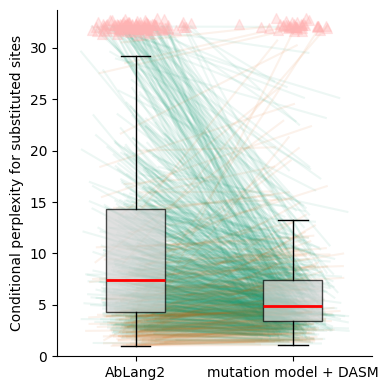

In [6]:
# First create a dataframe with the original and jittered positions
plot_df = pd.DataFrame({
    'AbLang2': output_df["AbLang2 perplexity"],
    'DASM': output_df["DASM perplexity"]
})

# Add jittered x positions
jitter_scale = 0.05
plot_df['x_ablang'] = 0.0 + np.random.normal(0, jitter_scale, len(plot_df))
plot_df['x_dasm'] = 0.4 + np.random.normal(0, jitter_scale, len(plot_df))

# Create plot
fig, ax = plt.subplots(figsize=(4, 4))

# Create box plot first (so it's behind the points)
data = [output_df["AbLang2 perplexity"], output_df["DASM perplexity"]]
labels = ['AbLang2', 'DASM']
positions = [0., 0.4]
bp = ax.boxplot(data, positions=positions, tick_labels=labels, patch_artist=True, showfliers=False)

# Customize box appearance
for box in bp['boxes']:
    box.set(facecolor='lightgray', alpha=0.7)
    box.set(edgecolor='black')

plt.setp(bp['whiskers'], color='black')
plt.setp(bp['caps'], color='black')
plt.setp(bp['medians'], color='red', linewidth=2)

# Get upper limit from boxplot calculation
upper_whisker = bp['whiskers'][1].get_ydata()[1]
y_limit = 1.1 * upper_whisker

# Add flags for outliers and color coding
plot_df['ablang_outlier'] = plot_df['AbLang2'] > y_limit
plot_df['dasm_outlier'] = plot_df['DASM'] > y_limit
plot_df['dasm_better'] = plot_df['DASM'] < plot_df['AbLang2']

# Draw lines connecting points
for _, row in plot_df.iterrows():
    color = '#1b9e77' if row['dasm_better'] else '#d95f02'
    y1 = min(row['AbLang2'], y_limit)
    y2 = min(row['DASM'], y_limit)
    if y1 != y2:
        ax.plot([row['x_ablang'], row['x_dasm']], [y1, y2], 
                color=color, alpha=0.08, zorder=1)

# Plot regular points
regular_mask = ~(plot_df['ablang_outlier'] | plot_df['dasm_outlier'])

# Plot outliers as triangles with jittered y positions
triangle_y_ablang = y_limit + np.random.normal(0, y_limit * 0.01, sum(plot_df['ablang_outlier']))
triangle_y_dasm = y_limit + np.random.normal(0, y_limit * 0.01, sum(plot_df['dasm_outlier']))

ax.scatter(plot_df.loc[plot_df['ablang_outlier'], 'x_ablang'], 
          triangle_y_ablang,
          s=50, color='#ffb3b3', marker='^', zorder=3, alpha=0.3)
ax.scatter(plot_df.loc[plot_df['dasm_outlier'], 'x_dasm'], 
          triangle_y_dasm,
          s=50, color='#ffb3b3', marker='^', zorder=3, alpha=0.3)

# Customize plot
ax.set_xlim(-0.2, 0.6)
ax.set_ylabel('Conditional perplexity for substituted sites')
ax.set_ylim(0, y_limit * 1.05)
ax.set_xticks([0.0, 0.4])
ax.set_xticklabels(['AbLang2', 'mutation model + DASM'])

sns.despine()
plt.tight_layout()

fig.savefig(localify(f"FIGURES_DIR/perplexity_comparison-{dataset_name}.svg"), bbox_inches='tight')

In [7]:
print("AbLang2 perplexity median:", output_df["AbLang2 perplexity"].median())
print("DASM perplexity median:", output_df["DASM perplexity"].median())

AbLang2 perplexity median: 7.3896885
DASM perplexity median: 4.876878384428696


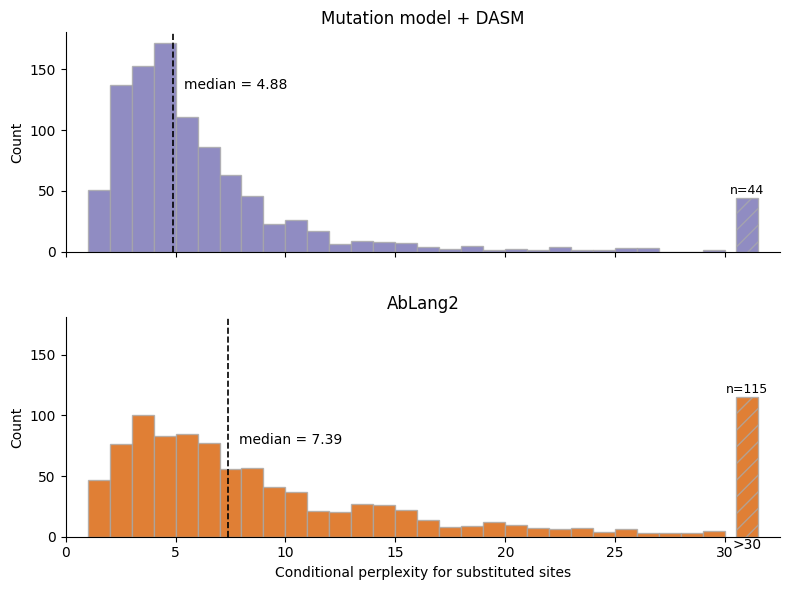

In [8]:
# Define the maximum perplexity to plot before collecting into outlier bin
max_perplexity = 30

# Create the plot - note the order is flipped with DASM on top now
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, sharey=True)

# Set up colormap using seaborn Dark2 colors for consistency
dark2_colors = sns.color_palette("Dark2")
ablang_color = dark2_colors[1]  # Orange
dasm_color = dark2_colors[2]    # Purple
edge_color = 'darkgray'

# Process data for histograms
# Count normal values with many bins, and collect outliers
bins = np.linspace(1, max_perplexity, 30)
bins = np.append(bins, np.inf)  # Add infinity as the last bin

# Create histograms
ablang_counts, _ = np.histogram(output_df["AbLang2 perplexity"], bins=bins)
dasm_counts, _ = np.histogram(output_df["DASM perplexity"], bins=bins)

# Get the bin centers for plotting (except for the outlier bin)
bin_centers = bins[:-2] + np.diff(bins[:-1])/2

# FLIPPED ORDER: Plot DASM on top (ax1) and AbLang on bottom (ax2)
ax1.bar(bin_centers, dasm_counts[:-1], width=np.diff(bins[:-1]), 
        align='center', color=dasm_color, alpha=0.8, edgecolor=edge_color)
ax2.bar(bin_centers, ablang_counts[:-1], width=np.diff(bins[:-1]), 
        align='center', color=ablang_color, alpha=0.8, edgecolor=edge_color)

# Add outlier bins separately with reduced alpha and hatching
outlier_x = max_perplexity + 1
outlier_width = np.diff(bins[:-1]).mean()
ax1.bar(outlier_x, dasm_counts[-1], width=outlier_width, 
       color=dasm_color, alpha=0.8, edgecolor=edge_color, hatch='//')
ax2.bar(outlier_x, ablang_counts[-1], width=outlier_width, 
       color=ablang_color, alpha=0.8, edgecolor=edge_color, hatch='//')

# Add annotations for outlier bars if they have counts
if dasm_counts[-1] > 0:
    ax1.text(outlier_x, dasm_counts[-1] + 1, f"n={dasm_counts[-1]}", 
            ha='center', va='bottom', fontsize=9)
if ablang_counts[-1] > 0:
    ax2.text(outlier_x, ablang_counts[-1] + 1, f"n={ablang_counts[-1]}", 
            ha='center', va='bottom', fontsize=9)

# Calculate medians
ablang_median = np.median(output_df["AbLang2 perplexity"])
dasm_median = np.median(output_df["DASM perplexity"])

# Get max height for each plot to position the median labels
max_height_dasm = max(dasm_counts[:-1]) * 0.8
max_height_ablang = max(ablang_counts[:-1]) * 0.8

# Add vertical dashed lines for median
ax1.axvline(dasm_median, color='black', linestyle='--', linewidth=1.2)
ax2.axvline(ablang_median, color='black', linestyle='--', linewidth=1.2)

# Add direct text labels for median values
ax1.text(dasm_median + 0.5, max_height_dasm, f'median = {dasm_median:.2f}', 
         ha='left', va='center', fontsize=10)
ax2.text(ablang_median + 0.5, max_height_ablang, f'median = {ablang_median:.2f}', 
         ha='left', va='center', fontsize=10)

# Set titles (without median values now since they're directly labeled)
ax1.set_title('Mutation model + DASM', fontsize=12)
ax2.set_title('AbLang2', fontsize=12)

# Label the outlier section
ax2.text(outlier_x, -1, f'>{max_perplexity}', ha='center', va='top', fontsize=10)

# Set plot labels and styling
ax2.set_xlabel('Conditional perplexity for substituted sites')
ax2.set_ylabel('Count')
ax1.set_ylabel('Count')

# Set the x-axis limit to include outlier bin
ax2.set_xlim(0, outlier_x + outlier_width/2 + 1)

# Remove top and right spines
sns.despine()

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)  # Increased spacing between subplots

# Save figure
fig.savefig(localify(f"FIGURES_DIR/perplexity_comparison-{dataset_name}.svg"), bbox_inches='tight')
plt.show()

In [9]:
def plot_perplexity_histogram(ax, output_df, max_perplexity=30, bin_count=30):
    """
    Plot a histogram of perplexity values for AbLang2 and DASM models.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes to plot on.
    output_df : pandas.DataFrame
        DataFrame containing the perplexity values.
    max_perplexity : int, optional
        Maximum perplexity to plot before collecting into outlier bin.
    """
    ablang_color = '#B3A875'  # For histogram bars
    ablang_text_color = '#8A805A'  # For text labels
    dasm_color = '#7570B3'    # Dark2 purple
    edge_color = '#444444'

    # Process data for histograms
    # Define bins up to but not including max_perplexity
    bins = list(np.linspace(1, max_perplexity, bin_count))

    # Create histograms
    ablang_values = output_df["AbLang2 perplexity"].copy()
    dasm_values = output_df["DASM perplexity"].copy()

    # Count number in the last bin
    ablang_last_bin = sum(ablang_values >= max_perplexity)
    dasm_last_bin = sum(dasm_values >= max_perplexity)

    # Plot histograms with regular bins
    ax.hist(ablang_values[ablang_values < max_perplexity], bins=bins, alpha=0.5, color=ablang_color, 
            edgecolor=edge_color, linewidth=0.5, label='AbLang2')
    ax.hist(dasm_values[dasm_values < max_perplexity], bins=bins, alpha=0.5, color=dasm_color, 
            edgecolor=edge_color, linewidth=0.5, label='Mutation model + DASM')

    # Add the last bin manually if there are any values
    if ablang_last_bin > 0:
        # Get the height of the last bin based on the bin width
        bin_width = bins[1] - bins[0]
        last_bin_height = ablang_last_bin / bin_width
        ax.bar(max_perplexity, last_bin_height, width=bin_width, alpha=0.5, color=ablang_color, 
               edgecolor=edge_color, linewidth=0.5)

    if dasm_last_bin > 0:
        bin_width = bins[1] - bins[0]
        last_bin_height = dasm_last_bin / bin_width
        ax.bar(max_perplexity, last_bin_height, width=bin_width, alpha=0.5, color=dasm_color, 
               edgecolor=edge_color, linewidth=0.5)

    # Calculate medians
    ablang_median = np.median(output_df["AbLang2 perplexity"])
    dasm_median = np.median(output_df["DASM perplexity"])

    # Get plot limits for positioning
    y_min, y_max = ax.get_ylim()
    text_y_position = y_max * 0.97
    line_y_top = y_max * 0.85  # Set the vertical line to go up to 85% of the plot height

    # Add vertical lines for medians with color matching the histograms
    ax.add_line(Line2D([ablang_median, ablang_median], [y_min, line_y_top], 
                      color=ablang_color, linestyle='--', linewidth=1.5))
    ax.axvline(x=dasm_median, color=dasm_color, linestyle='--', linewidth=1.5)

    # Add direct text labels for median values
    ax.text(dasm_median + 0.5, text_y_position, f'DASM median = {dasm_median:.2f}', 
            ha='left', va='center', fontsize=11, color=dasm_color)
    ax.text(ablang_median + 0.5, text_y_position - y_max * 0.25, f'AbLang2 median = {ablang_median:.2f}', 
            ha='left', va='center', fontsize=11, color=ablang_text_color)

    # Explicitly set x-ticks and labels to ensure "≥max_perplexity" appears
    tick_positions = list(range(0, max_perplexity+1, 5))
    tick_labels = [str(pos) for pos in tick_positions]
    # Change the last label to "≥max_perplexity"
    tick_labels[-1] = f"≥{max_perplexity}"
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)

    # Set plot labels and styling
    ax.set_xlabel('Conditional perplexity for substituted sites')
    ax.set_ylabel('Count')
    ax.set_xlim(0, max_perplexity)

    # Add legend with flipped order
    handles, labels = ax.get_legend_handles_labels()
    # Reverse the order of handles and labels
    handles = handles[::-1]
    labels = labels[::-1]
    ax.legend(handles, labels, loc='upper right')

    # Remove top and right spines
    sns.despine(ax=ax)

In [10]:

def plot_perplexity_kde(ax, output_df, max_perplexity=20, bandwidth_factor=0.5):
    """
    Plot a comparison of perplexity values for AbLang2 and DASM models using
    log-transformed KDE curves with customizable smoothing.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes to plot on.
    output_df : pandas.DataFrame
        DataFrame containing the perplexity values.
    max_perplexity : int, optional
        Maximum perplexity to plot.
    bandwidth_factor : float, optional
        Controls the amount of smoothing. Lower values = less smoothing.
        Default is 0.5 for less smoothing than the default (which would be 1.0).
    """
    dark2_colors = sns.color_palette("Dark2")
    ablang_color = dark2_colors[1]  # Orange
    dasm_color = dark2_colors[2]    # Purple

    # Create histograms
    ablang_values = output_df["AbLang2 perplexity"].copy()
    dasm_values = output_df["DASM perplexity"].copy()
    
    # Create a range of values for plotting that starts at a small positive value
    x_eval = np.linspace(1, max_perplexity, 1000)  # Start at 1 for perplexity
    
    # Filter out any zero or negative values to avoid log transform issues
    ablang_nonzero = ablang_values[ablang_values > 0]
    dasm_nonzero = dasm_values[dasm_values > 0]
    
    # Apply log transform
    ablang_log = np.log(ablang_nonzero)
    dasm_log = np.log(dasm_nonzero)
    
    # Calculate optimal bandwidths using Scott's rule
    # Then modify them by the bandwidth_factor to adjust smoothing
    def scotts_factor(x):
        return np.power(len(x), -1./(1+4)) * np.std(x)
    
    ablang_bw = scotts_factor(ablang_log) * bandwidth_factor
    dasm_bw = scotts_factor(dasm_log) * bandwidth_factor
    
    # Estimate densities in log space with custom bandwidths
    kde_ablang = stats.gaussian_kde(ablang_log, bw_method=ablang_bw)
    kde_dasm = stats.gaussian_kde(dasm_log, bw_method=dasm_bw)
    
    # Transform back to original space with Jacobian adjustment
    x_log = np.log(x_eval)
    density_ablang = kde_ablang(x_log) / x_eval
    density_dasm = kde_dasm(x_log) / x_eval
    
    # Plot the KDEs
    ax.plot(x_eval, density_ablang, color=ablang_color, linewidth=2, label='AbLang2')
    ax.plot(x_eval, density_dasm, color=dasm_color, linewidth=2, label='Mutation model + DASM')

    # Calculate medians
    ablang_median = np.median(output_df["AbLang2 perplexity"])
    dasm_median = np.median(output_df["DASM perplexity"])

    # Get plot limits for positioning
    y_min, y_max = ax.get_ylim()
    text_y_position = y_max * 0.95
    line_y_top = y_max * 0.85  # Set the vertical line to go up to 85% of the plot height

    # Add vertical lines for medians with color matching the KDEs
    ax.add_line(Line2D([ablang_median, ablang_median], [y_min, line_y_top], 
                      color=ablang_color, linestyle='--', linewidth=1.5))
    ax.axvline(x=dasm_median, color=dasm_color, linestyle='--', linewidth=1.5)

    # Add direct text labels for median values
    ax.text(dasm_median + 0.5, text_y_position, f'Thrifty + DASM (median = {dasm_median:.2f})', 
            ha='left', va='center', fontsize=11, color=dasm_color)
    ax.text(ablang_median + 0.5, text_y_position - y_max * 0.2, f'AbLang2 (median = {ablang_median:.2f})', 
            ha='left', va='center', fontsize=11, color=ablang_color)

    # Explicitly set x-ticks and labels 
    tick_positions = list(range(0, max_perplexity+1, 5))
    tick_labels = [str(pos) for pos in tick_positions]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)

    # Set plot labels and styling
    ax.set_xlabel('Conditional perplexity for substituted sites')
    ax.set_ylabel('Probability density')
    ax.set_xlim(0, max_perplexity)

    # Remove top and right spines
    sns.despine(ax=ax)

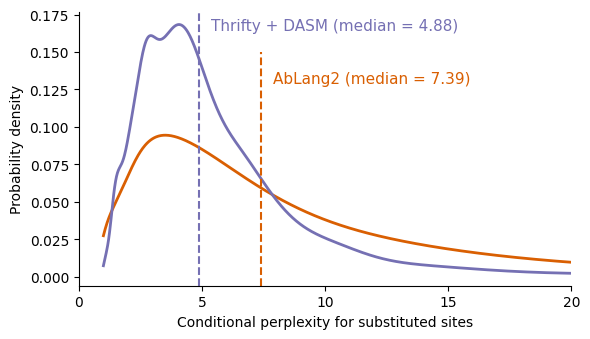

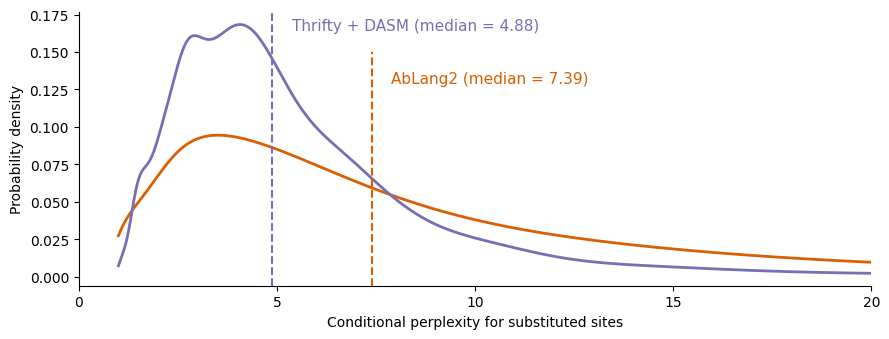

In [11]:
# Create regular plot
fig, ax = plt.subplots(figsize=(6, 3.5))
plot_perplexity_kde(ax, output_df)
plt.tight_layout()
fig.savefig(localify(f"FIGURES_DIR/perplexity_comparison-{dataset_name}.svg"), bbox_inches='tight')

# Create wide plot
wide_fig, wide_ax = plt.subplots(figsize=(9, 3.5))
plot_perplexity_kde(wide_ax, output_df)
plt.tight_layout()
wide_fig.savefig(localify(f"FIGURES_DIR/perplexity_comparison-{dataset_name}-wide.svg"), bbox_inches='tight')